# Galaxies: An interactive graduate course

## Chapter 8: The co-evolution of halos, gas, stars, and metals

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

In [2]:
import scipy
import copy

from colossus.halo import mass_so
from colossus.halo import concentration
from colossus.utils import constants

from routines import theory

Unlike the other notebookes, this one is not organized into the same subsections as the lecture notes. While the latter introduce different model physics step by step, we evaluate the time evolution and predictions of the model as a whole and then consider the individual components in detail. Our model is based on the equations in [Krumholz & Dekel 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...753...16K/abstract), [Feldmann 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.433.1910F/abstract), and [Kravtsov & Manwadkar 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.514.2667K/abstract).

### Setting up the model

This general parameter sets whether we save certain plots to file.

In [3]:
save_plots = False

We begin by evaluating our fiducial model for a grid of masses. The final halo mass at $z = 0$ is a very sensitive function of the initial redshift and mass. We tune our initial masses to give a representative range of final masses.

In [4]:
from routines import models

z_ini = 30.0
Mh_ini_array = 10**np.linspace(6.4, 7.85, 30)
n_M = len(Mh_ini_array)
fb = cmn.cosmo.Ob(0.0) / cmn.cosmo.Om(0.0)

def evaluateModel(verbose = False, **kwargs):

    dic = {}
    Mx_t = None
    model_array = []
    for i in range(n_M):
        if verbose:
            print('Evaluating for Mh_ini = %.2e...' % (Mh_ini_array[i]))
        m = models.GalaxyModel(z_ini, Mh_ini_array[i], **kwargs)
        t_, z_, a_, M_hist, dM_hist = m.evolve()
        if Mx_t is None:
            t = t_
            z = z_
            a = a_
            n_t = len(t)
            n_comp = M_hist.shape[0]
            Mx_t = np.zeros((n_M, n_comp, n_t), float)
            dMx_t = np.zeros((n_M, n_comp, n_t), float)
        Mx_t[i, :, :] = M_hist[:, :]
        dMx_t[i, :, :] = dM_hist[:, :]
        model_array.append(m)

    dic['models'] = model_array
    dic['t'] = t
    dic['z'] = z
    dic['Mx'] = Mx_t
    dic['dMx'] = dMx_t
        
    return dic

In [5]:
dic_fid = evaluateModel(verbose = True)

Evaluating for Mh_ini = 2.51e+06...
Evaluating for Mh_ini = 2.82e+06...
Evaluating for Mh_ini = 3.16e+06...
Evaluating for Mh_ini = 3.55e+06...
Evaluating for Mh_ini = 3.98e+06...
Evaluating for Mh_ini = 4.47e+06...
Evaluating for Mh_ini = 5.01e+06...
Evaluating for Mh_ini = 5.62e+06...
Evaluating for Mh_ini = 6.31e+06...
Evaluating for Mh_ini = 7.08e+06...
Evaluating for Mh_ini = 7.94e+06...
Evaluating for Mh_ini = 8.91e+06...
Evaluating for Mh_ini = 1.00e+07...
Evaluating for Mh_ini = 1.12e+07...
Evaluating for Mh_ini = 1.26e+07...
Evaluating for Mh_ini = 1.41e+07...
Evaluating for Mh_ini = 1.58e+07...
Evaluating for Mh_ini = 1.78e+07...
Evaluating for Mh_ini = 2.00e+07...
Evaluating for Mh_ini = 2.24e+07...
Evaluating for Mh_ini = 2.51e+07...
Evaluating for Mh_ini = 2.82e+07...
Evaluating for Mh_ini = 3.16e+07...
Evaluating for Mh_ini = 3.55e+07...
Evaluating for Mh_ini = 3.98e+07...
Evaluating for Mh_ini = 4.47e+07...
Evaluating for Mh_ini = 5.01e+07...
Evaluating for Mh_ini = 5.62

### Time evolution of the model components

#### Dark matter halos

Our model generates an accretion history from a formula for accretion rates. This leads to a fairly different history than suggested by [Wechsler et al. 2002](https://ui.adsabs.harvard.edu/abs/2002ApJ...568...52W/abstract). Let's plot the mass accretion histories.

In [6]:
def massAccretionHistory(Mvir, z):

    # Calculate concentration and formation redshift
    cvir = concentration.concentration(Mvir, 'vir', 0.0)
    ac = 4.1 / cvir

    Ma = np.zeros((len(Mvir), len(z)), float)
    for i in range(len(Mvir)):
        Ma[i, :] = Mvir[i] * np.exp(-2.0 * ac[i] * z)
    
    return Ma

In [7]:
def plotModelMAH(dic_model):

    idxs_plot = [0, n_M // 3, n_M // 3 * 2, n_M - 1]

    plt.figure()
    plt.yscale('log')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$M_{\rm h}\ (M_\odot)$')
    plt.xlim(0.0, dic_model['models'][0].z_ini)
    plt.ylim(1E5, 1E16)

    for i in range(len(idxs_plot)):
        Mz = dic_model['Mx'][idxs_plot[i]][models.IH]
        z = dic_model['z']
        mah_wechsler = massAccretionHistory(np.array([Mz[-1]]), z)
        if i == 0:
            label = r'$\mathrm{Wechsler\ et\ al.\ 2002}$'
        else:
            label = None
        plt.plot(z, mah_wechsler[0, :], ls = '--', color = cmn.color_cycle[i], label = label)
        plt.plot(z, Mz, label = r'$\log_{10} M_{\rm h,0} = %.1f$' % (np.log10(Mz[-1])))

    plt.legend()
    plt.show()

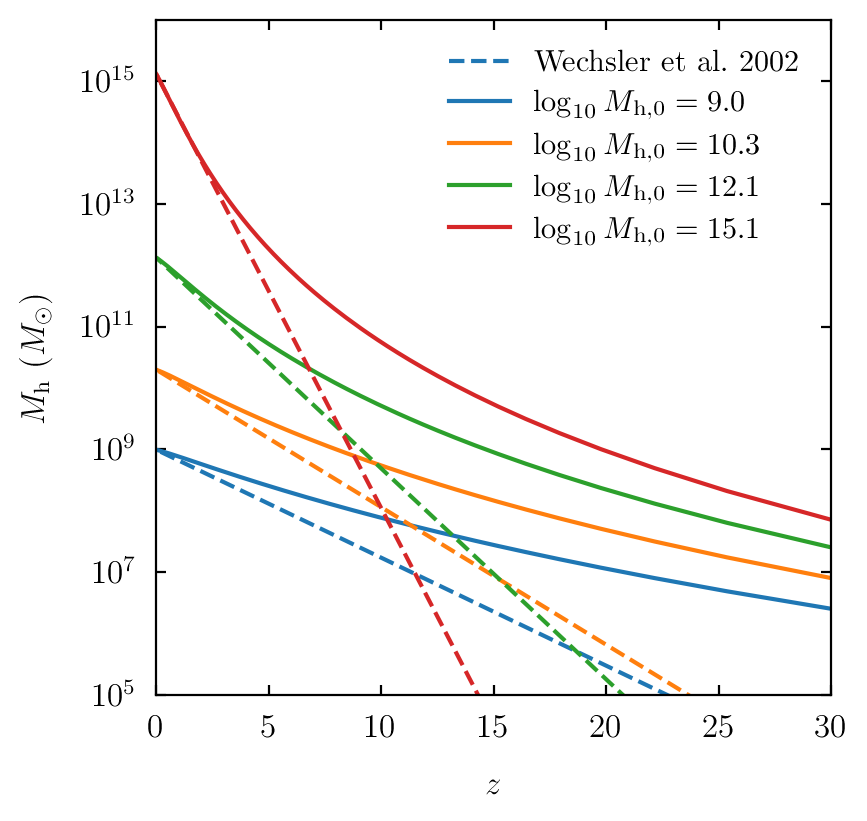

In [8]:
plotModelMAH(dic_fid)

#### All components

Let's plot the time evolution of all model components for a few representative mass bins.

In [9]:
def plotModelHistories(dic_model):

    idxs = [0, n_M // 2, int(n_M * 0.8), -1]
    n_halos = len(idxs)

    t = dic_model['t']
    model_0 = dic_model['models'][0]
    Mx = dic_model['Mx']
    dMx = dic_model['dMx']

    fig, ax = plt.subplots(2, n_halos, figsize = (10, 5))
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

    for i in range(len(idxs)):
        idx = idxs[i]

        for j in range(2):
            plt.sca(ax[j, i])
            plt.loglog()
            plt.xlim(t[0], t[-1])
            if j == 0:
                ax[j, i].set_xticklabels([])
                if i == 0:
                    plt.ylabel(r'$M_{\rm X} / M_{\rm h,0}$')
                else:
                    ax[j, i].set_yticklabels([])
                plt.ylim(2E-9, 4.0)
            else:
                plt.xlabel(r'$t\ ({\rm Gyr})$')
                if i == 0:
                    plt.ylabel(r'${\rm d} M_{\rm X} / {\rm d}t / M_{\rm h,0}\ ({\rm Gyr}^{-1})$')
                else:
                    ax[j, i].set_yticklabels([])
                plt.ylim(1E-9, 2.0)
            plt.xlim(t[0], t[-1])
            plt.axvline(cmn.cosmo.age(model_0.z_reion), ls = ':', color = 'gray', lw = 0.5)

        plt.sca(ax[0, i])
        Mh_0 = Mx[idx, models.IH, -1]
        plt.plot(t, Mx[idx, models.IH, :] / Mh_0, label = r'$\mathrm{Halo}$')
        plt.plot(t, Mx[idx, models.IG, :] / Mh_0, label = r'$\mathrm{Gas}$')
        plt.plot(t, Mx[idx, models.IS, :] / Mh_0, label = r'$\mathrm{Stars}$')
        plt.plot(t, Mx[idx, models.IZ, :] / Mh_0, label = r'$\mathrm{Metals}$')

        plt.sca(ax[1, i])
        plt.plot(t, dMx[idx, models.IH, :] / Mh_0)
        plt.plot(t, dMx[idx, models.IG, :] / Mh_0)
        plt.plot(t, dMx[idx, models.IS, :] / Mh_0)
        plt.plot(t, dMx[idx, models.IZ, :] / Mh_0)

        plt.sca(ax[0, i])
        plt.text(0.05, 0.9, r'$\log_{10} M_0 = %.1f$' % (np.log10(Mh_0)), transform = plt.gca().transAxes)
        if i == 1:
            plt.legend(loc = 4, frameon = True, labelspacing = 0.1)
    if save_plots:
        plt.savefig('sam_histories.pdf')
    else:
        plt.show()

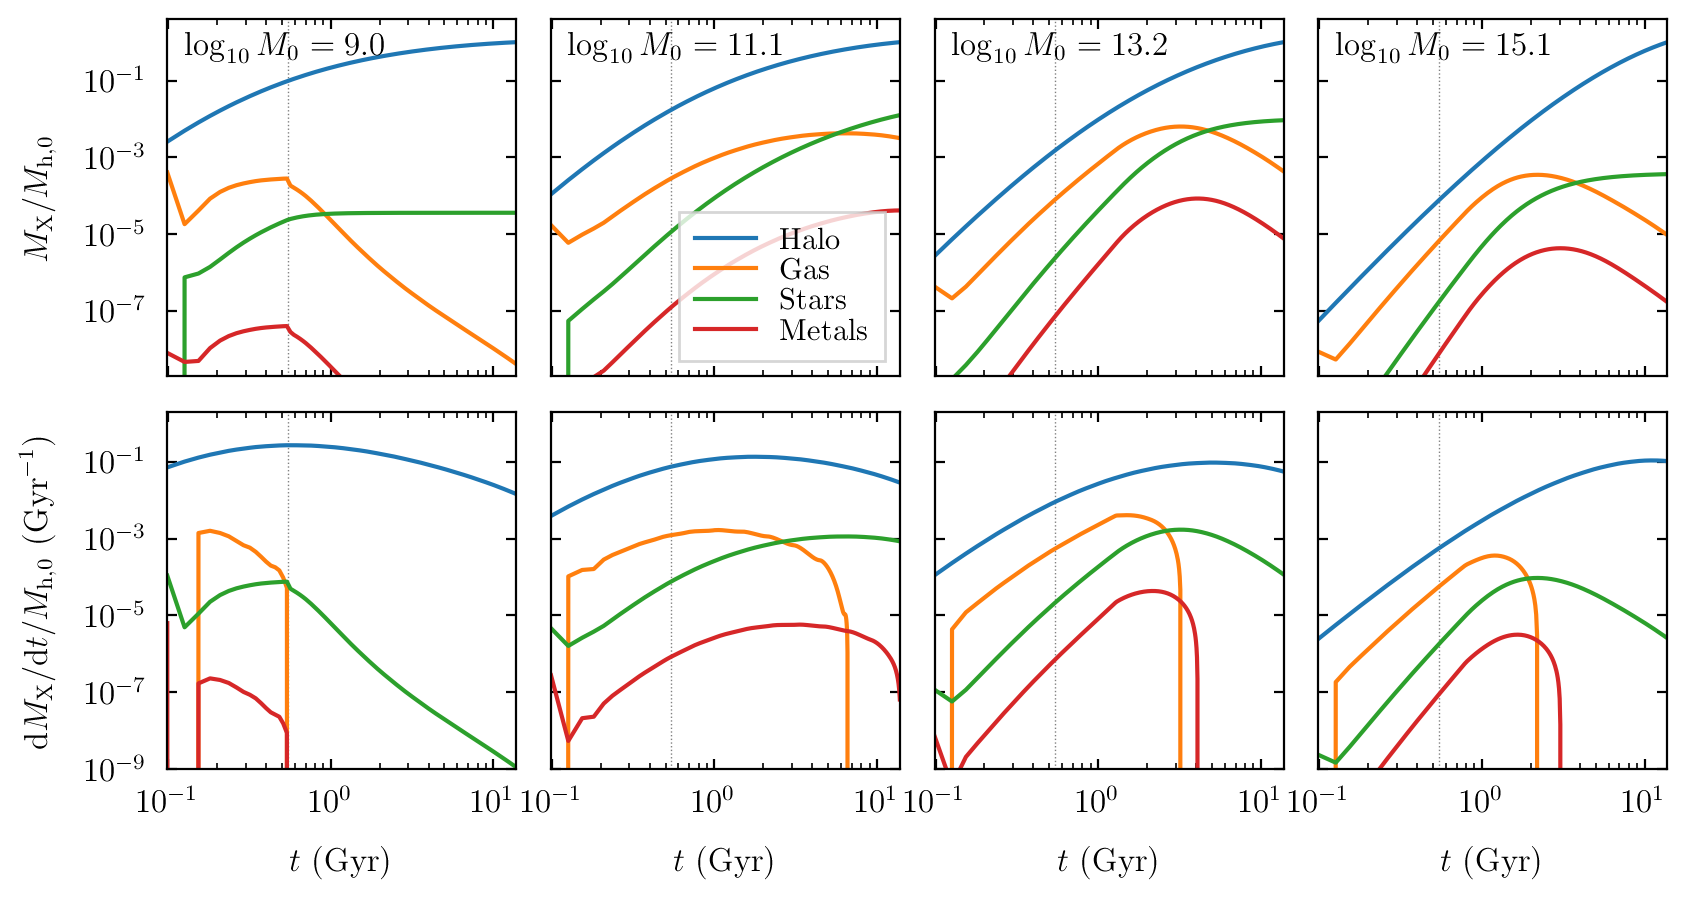

In [10]:
plotModelHistories(dic_fid)

The DM accretion histories (blue) are smooth as given by the fitting function. The other components show a clear break at the redshift of reionization, where the SFR of the smallest halos plummets to zero. The rates in larger halos recover but eventually begin declining as gas accretion becomes less efficient.

### Comparison to observations

We will compare our model (and its variations) to a few key benchmarks, namely
* The stellar mass-halo mass relation (SHMR) at $z = 0$ as parameterized by [Behroozi et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...770...57B/abstract), [Kravtsov et al. 2018](https://ui.adsabs.harvard.edu/abs/2018AstL...44....8K/abstract), and [Munshi et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...923...35M/abstract). These works cover different mass ranges and the differences between them guide us as to some residual observational uncertainties.
* The cosmic star formation density (SFRD) history as summarized by [Madau & Dickinson 2014](https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..415M/abstract).
* The mass-metallicity relation at $z = 0$ according to [Tremonti et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ApJ...613..898T/abstract) and [Berg et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...98B/abstract).

We need to renormalize the SFRD because the fitting function for the SFRD leads to $\sim 4$ times more total stellar mass at $z = 0$ than the models for the SHMR. Part of this difference comes from the difference between stellar mass created initially and stars remaining after mass return to the ISM, but even after correcting for this factor, a significant difference remains. Thus, our model cannot possibly match both sets of observations. We begin by computing the normalizations for each model, i.e., the total stellar density at $z = 0$. To do this, we need to convolve the stellar masses for each halo mass with the halo mass function, for which we assume the model of [Despali et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.2486D/abstract).

In [11]:
from colossus.lss import mass_function

def sfrdMadau(z):
    
    return 0.015 * (1.0 + z)**2.7 / (1.0 + ((1.0 + z) / 2.9)**5.6) * 1E9

def sfrdMadauTime(t):
    
    z = cmn.cosmo.age(t, inverse = True)
    
    return sfrdMadau(z)

def integrandSHMR(lnM, model, table_ln_Mh, table_ln_Ms):
    
    M = np.exp(lnM)
    M_h = M * h
    mfunc = mass_function.massFunction(M_h, 0.0, q_in = 'M', q_out = 'dndlnM', model = 'despali16', mdef = 'vir')
    mfunc *= h**3
    if model == 'behroozi13':
        mstar = theory.mstarBehroozi13(M, 0.0)
    elif model == 'kravtsov18':
        mstar = theory.mstarKravtsov18(M, scatter = False)
    elif model == 'table':
        mstar = np.exp(np.interp(lnM, table_ln_Mh, table_ln_Ms))
    else:
        raise Exception('Unknown model, %s' % (model))
    
    return mfunc * mstar

h = cmn.cosmo.h

# Integrate the Madau & Dickinson function over time to find the stellar density at z = 0
t1 = cmn.cosmo.age(15.0)
t2 = cmn.cosmo.age(0.0)
rho_star_madau, _ = scipy.integrate.quad(sfrdMadauTime, t1, t2, epsrel = 1E-4)

# Integrate the Behroozi function times mass function at z = 0
M0 = 1E6
M1 = 5E15
args = ('behroozi13', None, None)
rho_star_beh, _ = scipy.integrate.quad(integrandSHMR, np.log(M0), np.log(M1), args = args, epsrel = 1E-4)
args = ('kravtsov18', None, None)
rho_star_kra, _ = scipy.integrate.quad(integrandSHMR, np.log(M0), np.log(M1), args = args, epsrel = 1E-4)

# Integrate the SHMR predicted by our model
Mx_ = dic_fid['Mx']
Mh_ = Mx_[:, models.IH, -1]
Ms_ = Mx_[:, models.IS, -1]
args = ('table', np.log(Mh_), np.log(Ms_))
rho_star_model_shmr, _ = scipy.integrate.quad(integrandSHMR, np.log(Mh_[0]), np.log(Mh_[-1]), 
                                              args = args, epsrel = 1E-4)

# Print results
print('Total log10 of stellar density in Msun / Mpc^3 at z = 0:')
print('SFRD (Madau & Dickinson): %.2f' % (np.log10(rho_star_madau)))
print('SHMR (Behroozi):          %.2f' % (np.log10(rho_star_beh)))
print('SHMR (Kravtsov):          %.2f' % (np.log10(rho_star_kra)))
print('SHMR (Our model):         %.2f' % (np.log10(rho_star_model_shmr)))

/Users/benedito/University/code/mypy/teaching/astr620/routines/theory.py:119: RuntimeWarning: overflow encountered in exp
  f = -np.log10(10**(alpha * x) + 1.0) + delta * (np.log10(1.0 + np.exp(x)))**gamma / (1.0 + np.exp(10**(-x)))
/Users/benedito/University/code/mypy/teaching/astr620/routines/theory.py:165: RuntimeWarning: overflow encountered in exp
  t3 = 1.0 + np.exp(10**(-x))


Total log10 of stellar density in Msun / Mpc^3 at z = 0:
SFRD (Madau & Dickinson): 8.91
SHMR (Behroozi):          8.25
SHMR (Kravtsov):          8.50
SHMR (Our model):         8.31


We also need to compute the SFRD of our models by summing over the SFRs at each halo mass. We again do this by convolving with the halo mass function. However, there is a choice we need to make: we can assume the mass evolution given by our model, i.e., by the fitting function for the halo accretion rate. In that case, we compute the mass function once at $z = 0$ and assume that the density of halos in each mass bin stayed fixed. In other words, halos evolve along the mass trajectories prescribed by the model. Alternatively, we can evaluate the halo mass function (according to some model) at each redshift, thus adding information about the "true" evolution of halo masses from $N$-body simulations. We implement both options, the former is chosen if ``use_model_halo_evo == True``.

We could numerically integrate similarly to the function above, but a simple sum over bins turns out to be virtually as accurate and much faster. We only use every 10th redshift bin to save time.

In [12]:
def computeSFRD(model_dic, use_model_halo_evo = False):

    zs = model_dic['z']
    Mx = model_dic['Mx']
    dMx = model_dic['dMx']
    
    idxs_plot = np.arange(len(zs))
    idxs_plot = idxs_plot[::10]
    idxs_plot = np.concatenate((idxs_plot, [len(zs) - 1]))
    mask = (zs[idxs_plot] < 8)
    idxs_plot = idxs_plot[mask]
    zs_plot = zs[idxs_plot]

    # Pre-compute the mass function at z = 0 once and use it at all redshifts if we are assuming the model
    # halo mass evolution. The mass function is in units of dN / dln(M) (Mpc^-3), so we multiply with the 
    # width of bins in ln(M) space.
    if use_model_halo_evo:
        Mh_0 = Mx[:, models.IH, -1]
        mfunc = mass_function.massFunction(Mh_0 * h, 0.0, q_in = 'M', q_out = 'dndlnM', model = 'despali16', 
                                           mdef = 'vir') * h**3
        ln_M_centers = np.log(Mh_0)
        ln_M_edges = 0.5 * (ln_M_centers[1:] + ln_M_centers[:-1])
        ln_M_edges = np.concatenate((np.array([ln_M_centers[0]]), ln_M_edges, np.array([ln_M_centers[-1]])))
        dlnM0 = np.diff(ln_M_edges)
        mfunc_dlnM0 = mfunc * dlnM0

    sfr_tot = np.zeros_like(idxs_plot, float)
    for i in range(len(idxs_plot)):

        idx = idxs_plot[i]
        z = zs_plot[i]
        dMs = dMx[:, models.IS, idx]

        if use_model_halo_evo:
            mfunc_dlnM = mfunc_dlnM0
        else:
            Mh_z = Mx[:, models.IH, idx]
            mfunc = mass_function.massFunction(Mh_z * h, z, q_in = 'M', q_out = 'dndlnM', model = 'despali16', 
                                           mdef = 'vir') * h**3
            ln_M_centers = np.log(Mh_z)
            ln_M_edges = 0.5 * (ln_M_centers[1:] + ln_M_centers[:-1])
            ln_M_edges = np.concatenate((np.array([ln_M_centers[0]]), ln_M_edges, np.array([ln_M_centers[-1]])))
            dlnM = np.diff(ln_M_edges)
            mfunc_dlnM = mfunc * dlnM

        # "Integrate" by bins, returning the SFRD in Msun/yr/Mpc^3. Note that dMs_dt already includes 
        # the (1 - R) factor, i.e., refers to the eventual mass of stars remaining. 
        sfr_tot[i] = np.sum(dMs * mfunc_dlnM)

    return zs_plot, sfr_tot

sfrd_z, sfrd_model = computeSFRD(dic_fid)

We can now perform a sanity check: integrating the SFRD of our model over time should give (almost) the same total stellar density as integrating the SHMR at $z = 0$.

In [13]:
def integrandSFRD(t, table_t, table_sfrd):
    
    return np.interp(t, table_t, table_sfrd)

ts = cmn.cosmo.age(sfrd_z)
t0 = ts[0]
t1 = ts[-1]
args = (ts, sfrd_model)
rho_star_model_sfrd, _ = scipy.integrate.quad(integrandSFRD, t0, t1, args = args, epsrel = 1E-4)

print('SFRD (Our model):         %.2f' % (np.log10(rho_star_model_sfrd)))
print('The ratio of stellar densities computed from SHMR and SFRD is %.3f.' \
      % (rho_star_model_shmr / rho_star_model_sfrd))

SFRD (Our model):         8.58
The ratio of stellar densities computed from SHMR and SFRD is 0.535.


Depending on the ``use_model_halo_evo`` parameter, the total mass estimates from SHMR and SFRD may not agree as explained above. When we plot the SFRD, we renormalize it and plot the range between the total stellar densities corresponding to the Behroozi and Kravtsov SHMR models. We divide the SFRD by $(1 - {\cal R})$ since it should correspond to stars formed rather than stars remaining.

In [14]:
from matplotlib.ticker import LogLocator

Mmin_shmr = 1E9
Mmax_shmr = 1.2E15
zmax = 8.0
R_loss_def = 0.46

# Behroozi+2013 SHMR
Mvir_beh = 10**np.linspace(np.log10(Mmin_shmr), np.log10(Mmax_shmr), 200)
mstar_beh = theory.mstarBehroozi13(Mvir_beh, 0.0)
mask = (mstar_beh >= 10**7.25)
Mvir_beh = Mvir_beh[mask]
mstar_beh = mstar_beh[mask]

# Kravtsov+2018
Mvir_kra = 10**np.linspace(10.0, 15.2, 200)
mstar_kra = theory.mstarKravtsov18(Mvir_kra, scatter = True)

# Munshi+2021
Mh_crit = 1E10
norm = 1E7
Mvir_mun = 10**np.linspace(7.0, 11.0, 50)
mstar_mun = np.zeros_like(Mvir_mun)
scatter_mun = np.zeros_like(Mvir_mun)
mask = (Mvir_mun > Mh_crit)
mstar_mun[mask] = norm * (Mvir_mun[mask] / Mh_crit)**1.9
scatter_mun[mask] = 0.3
mask = np.logical_not(mask)
mstar_mun[mask] = norm * (Mvir_mun[mask] / Mh_crit)**2.81
scatter_mun[mask] = 0.3 - 0.39 * (np.log10(Mvir_mun[mask]) - 10.0)
y_mun = mstar_mun / Mvir_mun / fb
y_mun_lo = y_mun / 10**scatter_mun
y_mun_hi = y_mun * 10**scatter_mun

# Renormalize Madau curves
log_z1_min = 0.0
log_z1_max = np.log10(1.0 + zmax)
log_z1_plot = np.linspace(log_z1_min, log_z1_max, 50)
z_plot = 10**log_z1_plot - 1.0
sfrd_madau_ori = sfrdMadau(z_plot)
sfrd_madau_beh = sfrd_madau_ori * rho_star_beh / rho_star_madau / (1.0 - R_loss_def)
sfrd_madau_kra = sfrd_madau_ori * rho_star_kra / rho_star_madau / (1.0 - R_loss_def)

# Tremonti et al. 2004
log_Ms_tremonti = np.linspace(8.5, 11.5, 50)
log_OH_tremonti = -1.492 + 1.847 * log_Ms_tremonti - 0.08026 * log_Ms_tremonti**2
Z_tremonti = 10**(log_OH_tremonti - cmn.LOG_OH_SOLAR)
Z_tremonti_lo = Z_tremonti / 10**0.1
Z_tremonti_hi = Z_tremonti * 10**0.1

# Berg et al. 2012
log_Ms_berg = np.linspace(5.0, 10.0, 50)
log_OH_berg = 5.61 + 0.29 * log_Ms_berg
Z_berg = 10**(log_OH_berg - cmn.LOG_OH_SOLAR)
Z_berg_lo = Z_berg / 10**0.15
Z_berg_hi = Z_berg * 10**0.15

def plotModels(model_dics, labels, show_all_labels = False, shmr_y_max = 7E-1, use_model_halo_evo = True,
              mz_y_max = 5E0, save = False, fn_out = 'sam_results.pdf'):

    fig, ax = plt.subplots(1, 3, figsize = (11, 3.1))
    plt.subplots_adjust(hspace = 0.1, wspace = 0.35)

    # Prepare SHMR plot
    plt.sca(ax[0])
    plt.loglog()
    plt.xlim(Mmin_shmr, Mmax_shmr)
    plt.ylim(3E-4, shmr_y_max)
    plt.xlabel(r'$M_{\rm vir}\ (M_\odot)$')
    plt.ylabel(r'$M_\ast / M_{\rm vir} / f_{\rm b}$', labelpad = 5)
    plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
    plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))
    
    # Behroozi
    if show_all_labels:
        label = r'$\mathrm{Behroozi+2013}$'
    else:
        label = None
    plt.plot(Mvir_beh, mstar_beh / Mvir_beh / fb, ls = '--', c = 'gray', label = label)

    # Kravtsov
    if show_all_labels:
        label = r'$\mathrm{Kravtsov+2018}$'
    else:
        label = None
    plt.plot(Mvir_kra, mstar_kra / Mvir_kra / fb, ls = '-.', c = 'gray', label = label)

    # Munshi
    plt.fill_between(Mvir_mun, y_mun_lo, y_mun_hi, color = 'gray', alpha = 0.2)
    if show_all_labels:
        label = r'$\mathrm{Munshi+2021}$'
    else:
        label = None
    plt.plot(Mvir_mun, y_mun, ls = ':', c = 'gray', label = label)

    # Prepare SFRD plot
    plt.sca(ax[1])
    plt.xlabel(r'$\log_{10} (1 + z)$')
    plt.ylabel(r'$\Psi\ (M_\odot / {\rm yr} / {\rm Mpc}^3)$', labelpad = 5)
    plt.yscale('log')
    plt.xlim(log_z1_min, log_z1_max)

    # Madau & Dickinson
    if show_all_labels:
        label = r'$\mathrm{MD14,\ renormalized}$'
        plt.plot(log_z1_plot, sfrd_madau_ori, color = 'gray', ls = '--', 
                 label = r'$\mathrm{MD14,\ original}$')    
    else:
        label = None
    plt.fill_between(log_z1_plot, sfrd_madau_beh, sfrd_madau_kra, color = 'gray', alpha = 0.3, label = label)

    # Prepare metallicity plot
    plt.sca(ax[2])
    plt.xlabel(r'$M_\star\ (M_\odot)$')
    plt.ylabel(r'$Z / Z_\odot$', labelpad = 5)
    plt.loglog()
    plt.xlim(5E4, 5E11)
    plt.ylim(8E-3, mz_y_max)
    plt.gca().xaxis.set_major_locator(LogLocator(numticks = 100))
    plt.gca().xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

    plt.fill_between(10**log_Ms_tremonti, Z_tremonti_lo, Z_tremonti_hi, color = 'gray', alpha = 0.2)
    plt.plot(10**log_Ms_tremonti, Z_tremonti, color = 'gray', ls = '-.', label = r'$\mathrm{Tremonti+2004}$')

    plt.fill_between(10**log_Ms_berg, Z_berg_lo, Z_berg_hi, color = 'gray', alpha = 0.2)
    plt.plot(10**log_Ms_berg, Z_berg, color = 'gray', ls = '--', label = r'$\mathrm{Berg+2012}$')

    # Plot models
    for i in range(len(model_dics)):
        
        Mx = model_dics[i]['Mx']
        Mh_0 = Mx[:, models.IH, -1]
        Mg_0 = Mx[:, models.IG, -1]
        Ms_0 = Mx[:, models.IS, -1]
        MZ_0 = Mx[:, models.IZ, -1]
        
        # Compute the SFRD history of our model. We increase the SFR history by a factor of 1 / (1 - R)
        # since more stars were formed than remain today, the latter being what our function returns.
        # If we are not using the model's halo mass history but a mass function fit instead, then the
        # ratio between the SFRD and the total mass implied by the SHMR today can differ quite a bit. In
        # that case, we renormalize the SFRD such that it corresponds to the same total stellar mass as 
        # the SHMR of the model today.
        sfrd_z, sfrd_model = computeSFRD(model_dics[i], use_model_halo_evo = use_model_halo_evo)
        sfrd_model /= (1.0 - R_loss_def)
        if not use_model_halo_evo:
            sfrd_model *= rho_star_model_shmr / rho_star_model_sfrd
        
        if i == 0:
            lw = 2.0
        else:
            lw = 1.0
        
        plt.sca(ax[0])
        plt.plot(Mh_0, Ms_0 / Mh_0 / fb, lw = lw, label = labels[i])
        
        plt.sca(ax[1])
        plt.plot(np.log10(sfrd_z + 1.0), sfrd_model, lw = lw)

        plt.sca(ax[2])
        plt.plot(Ms_0, MZ_0 / Mg_0 / cmn.Z_SOLAR, lw = lw)

    plt.sca(ax[0]) 
    plt.legend(frameon = True, labelspacing = 0.2, loc = 8)
    if show_all_labels:
        plt.sca(ax[1]) 
        plt.legend(frameon = True, labelspacing = 0.2, loc = 8)
        plt.sca(ax[2]) 
        plt.legend(frameon = True, labelspacing = 0.2, loc = 8)
    if save:
        plt.savefig(fn_out)
    else:
        plt.show()

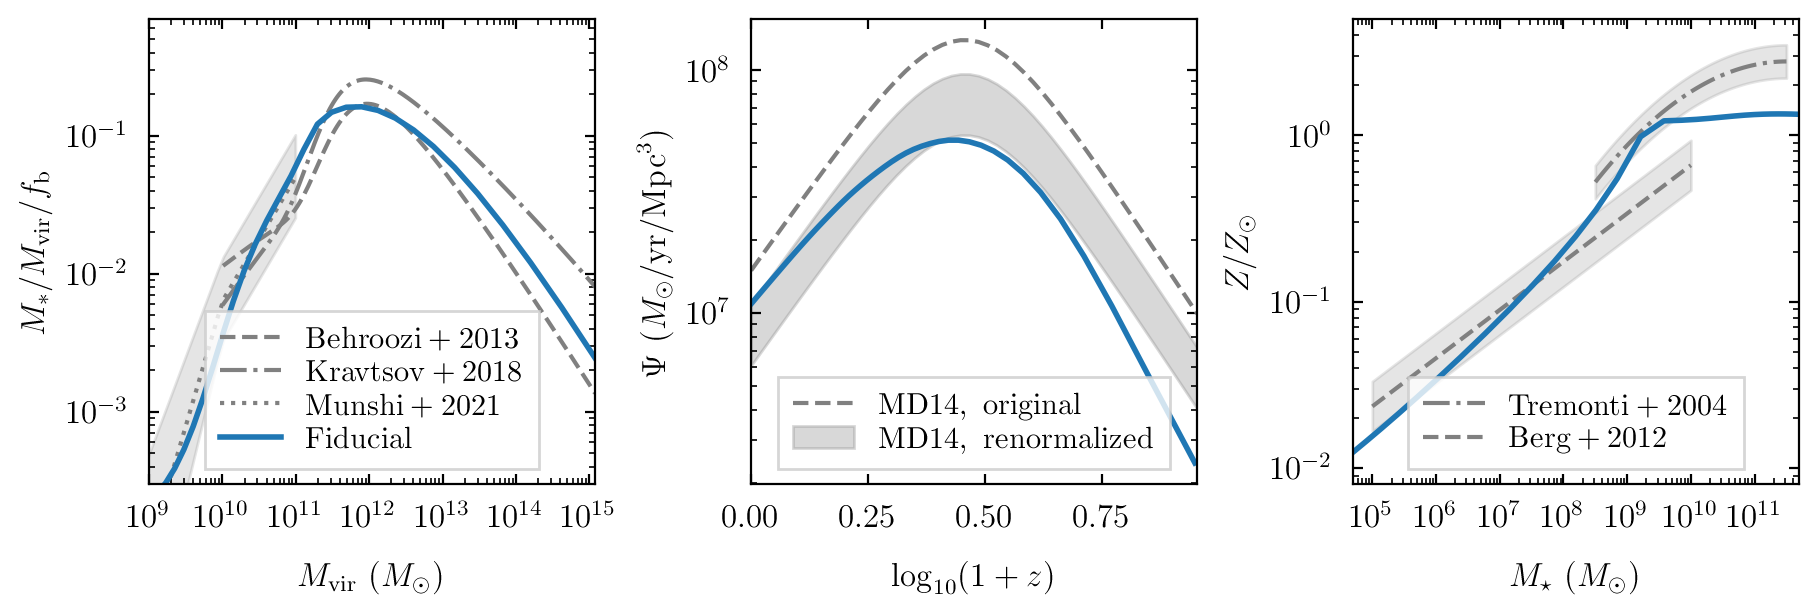

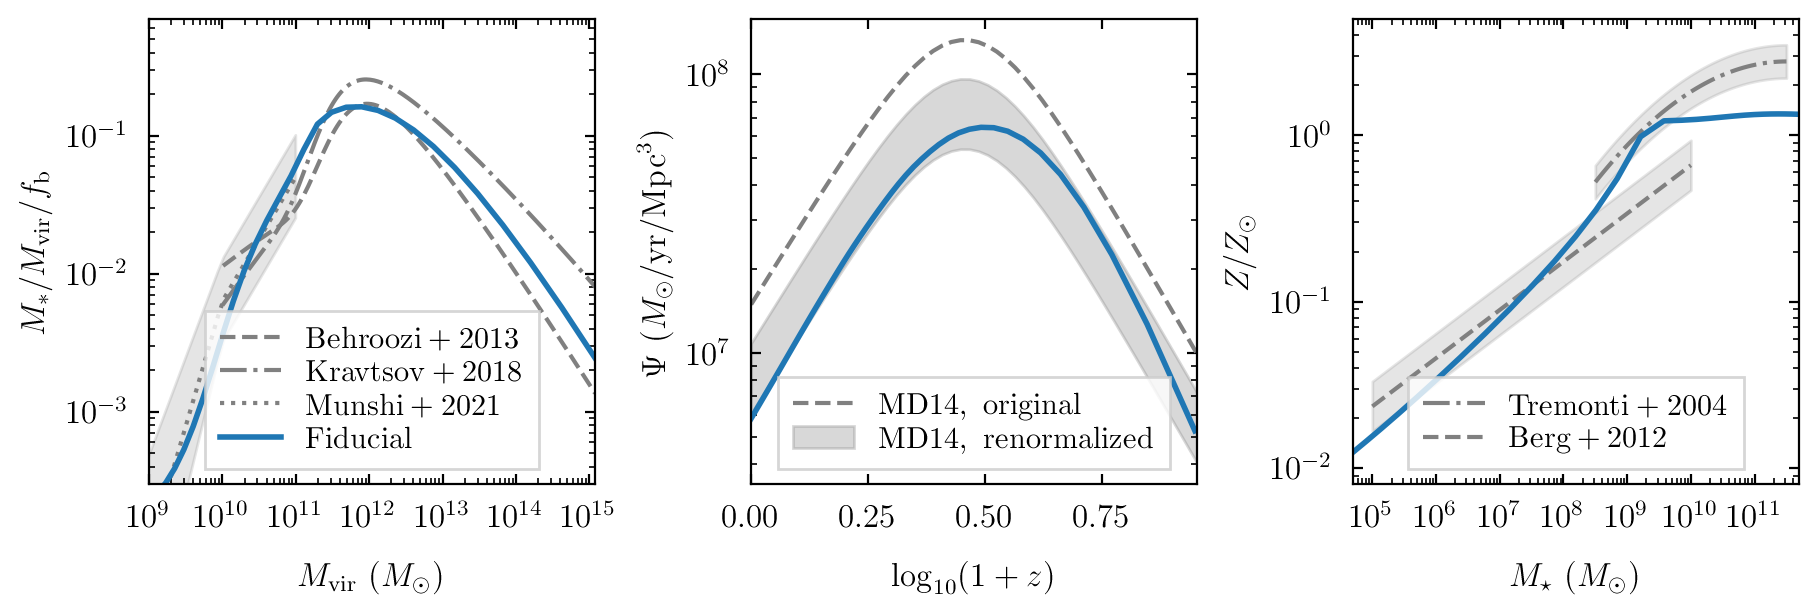

In [15]:
plotModels([dic_fid], [r'$\mathrm{Fiducial}$'], show_all_labels = True, use_model_halo_evo = True,
          save = save_plots, fn_out = 'sam_fiducial.pdf')
plotModels([dic_fid], [r'$\mathrm{Fiducial}$'], show_all_labels = True, use_model_halo_evo = False)

Our model matches the observational data well! The detailed calculation of the SFRD (using our model's halo evolution or a mass function fit's evolution) clearly makes quite a bit of difference. 

### Investigating the physics

Let's deconstruct our model by starting from one that has no models for gas accretion and star formation suppression of any kind. Then we will successively improve this model and check the impact of the free parameters along the way.

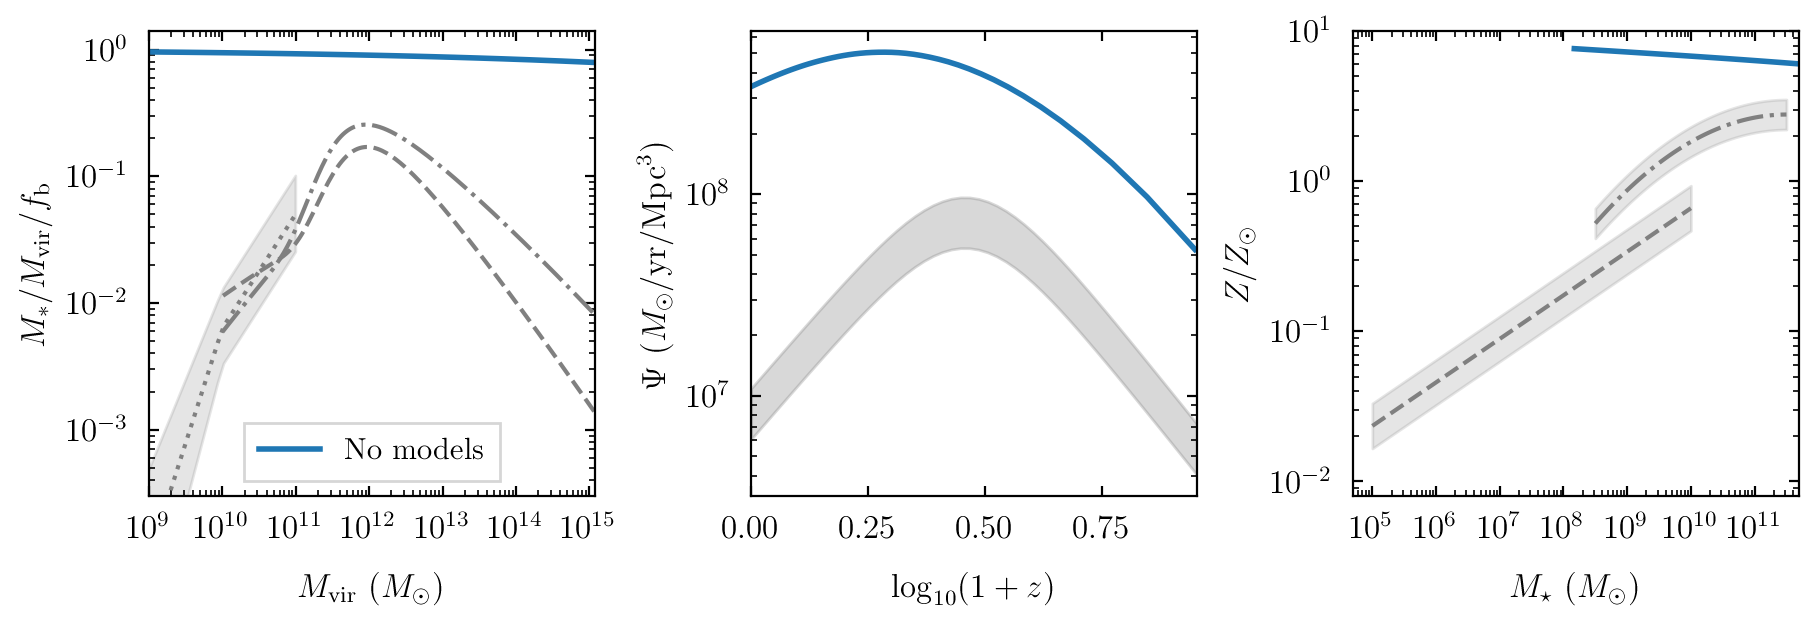

In [16]:
pars_cur = dict(model_reion = 'none', model_cooling = 'none', model_wind = 'none', R_loss = 0.0, eta_min = 0.0)
dic_cur = evaluateModel(**pars_cur)

Mx_models = [dic_cur]
labels = [r'$\mathrm{No\ models}$']
plotModels(Mx_models, labels, shmr_y_max = 1.4, mz_y_max = 1E1)

If we do not suppress gas accretion, all halos form stars at the same efficiency of unity; the slight deviations in the plot must be numerical.

#### General gas accretion and cooling efficiencies

We are imposing a lower cutoff mass from reionization and an upper cutoff due to long cooling times. We begin by plotting the redshift evolution of the respective critical halo masses.

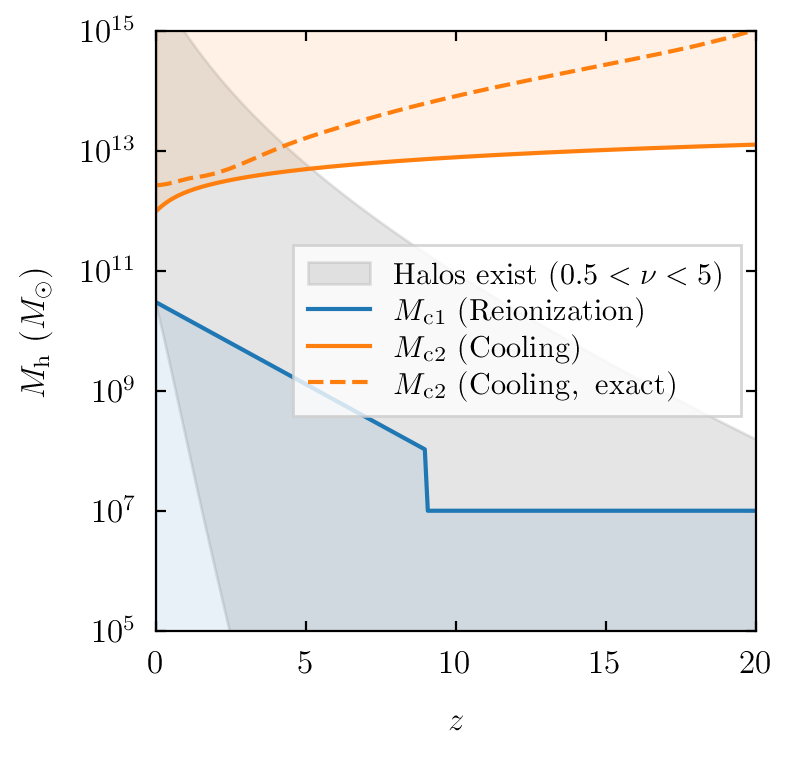

In [36]:
from colossus.lss import peaks

z = np.linspace(0.0, 20.0, 200)
n_z = len(z)
Z = 0.01

def eq(Mvir, z, Z):
    
    tcool = theory.tcoolFromMvir(Mvir, z, Z) / constants.GYR
    t = cmn.cosmo.age(z)
    
    return tcool - t

model_0 = dic_cur['models'][0]

# Mass at which cooling becomes inefficient
M_c2 = model_0.M_c2_0 * np.sqrt(cmn.cosmo.Ez(z)) * mass_so.deltaVir(z) / mass_so.deltaVir(0.0)

# Cutoff mass due to reionization
M_c1 = np.ones_like(M_c2) * model_0.M_c1_early
mask = (z < model_0.z_reion)
M_c1[mask] = model_0.M_c1_0 / cmn.cosmo.h * np.exp(-0.63 * z[mask])

# Numerical version
Mmin_plot = 1E11
Mmax_plot = 1E15
M_equal = np.ones((n_z), float)
mask = np.ones((n_z), bool)
for i in range(n_z):
    args = (z[i], Z)
    if eq(Mmin_plot * 1.0001, *args) * eq(Mmax_plot * 0.999, *args) < 0.0:
        M_equal[i] = scipy.optimize.brentq(eq, Mmin_plot * 1.0001, Mmax_plot * 0.999, args = args)
    else:
        mask[i] = False

M_nu_5 = peaks.massFromPeakHeight(5.0, z)
M_nu_05 = np.ones_like(M_nu_5) * 1E-10
mask_nu = (z < 10.0)
M_nu_05[mask_nu] = peaks.massFromPeakHeight(0.5, z[mask_nu])

plt.figure(figsize = (4.0, 4.0))
plt.xlabel(r'$z$')
plt.ylabel(r'$M_{\rm h}\ (M_\odot)$')
plt.yscale('log')
plt.xlim(z[0], z[-1])
plt.ylim(1E5, 1E15)

plt.fill_between(z, M_nu_05, M_nu_5, interpolate = True, color = 'gray', alpha = 0.2, 
                 label = r'$\mathrm{Halos\ exist}\ (0.5 < \nu < 5)$')

plt.fill_between(z, M_c1, 1E-5, interpolate = True, color = cmn.color_cycle[0], alpha = 0.1)
plt.plot(z, M_c1, color = cmn.color_cycle[0], label = r'$M_{\rm c1}\ \mathrm{(Reionization)}$')

plt.fill_between(z, M_c2, 1E20, interpolate = True, color = cmn.color_cycle[1], alpha = 0.1)
plt.plot(z, M_c2, color = cmn.color_cycle[1], label = r'$M_{\rm c2}\ \mathrm{(Cooling)}$')

plt.plot(z[mask], M_equal[mask], color = cmn.color_cycle[1], ls = '--', 
         label = r'$M_{\rm c2}\ \mathrm{(Cooling,\ exact)}$')

plt.legend(frameon = True, labelspacing = 0.2)
if save_plots:
    plt.savefig('sam_mc_gas.pdf')
else:
    plt.show()

The match between the exact and approximate $M_{\rm c2}$ curves looks bad, but this limit is relevant really only at low redshift since halos this massive do not exist at high $z$ (gray curves). Let's plot the combined baryon efficiency from both factors.

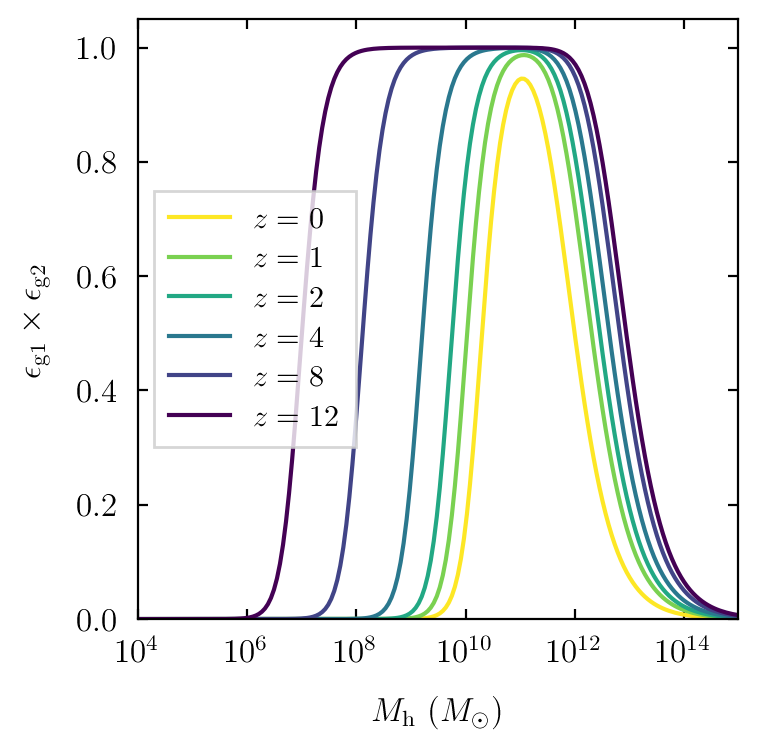

In [37]:
Mh_test = 10**np.linspace(4.0, 15.0, 200)
zs = [0, 1, 2, 4, 8, 12]
cmap = plt.get_cmap('viridis_r')
model_fid = dic_fid['models'][0]

plt.figure(figsize = (4.0, 4.0))
plt.xscale('log')
plt.xlabel(r'$M_{\rm h}\ (M_\odot)$')
plt.ylabel(r'$\epsilon_{\rm g1} \times \epsilon_{\rm g2}$')
plt.xlim(Mh_test[0], Mh_test[-1])
plt.ylim(0.0, 1.05)

for i, z in enumerate(zs):
    t = cmn.cosmo.age(z)
    total_eff = model_fid.eps_g1(t, [Mh_test]) * model_fid.eps_g2(t, [Mh_test])
    c = cmap(float(i) / (len(zs) - 1.0))
    plt.plot(Mh_test, total_eff, c = c, label = r'$z = %s$' % (str(z)))

plt.legend(frameon = True)
if save_plots:
    plt.savefig('sam_gas_eff.pdf')
else:
    plt.show()

We see how the range of halo masses where gas accretion and cooling is efficient shrinks with time. Let's plot how the two efficiency factors affect our model outputs, absent other physics.

In [19]:
pars_cur.update(dict(model_reion = 'okamoto08'))
dic_reion = evaluateModel(**pars_cur)

pars_cur.update(dict(model_cooling = 'cutoff', model_reion = 'none'))
dic_coolcut = evaluateModel(**pars_cur)

del pars_cur['model_reion']
del pars_cur['model_cooling']

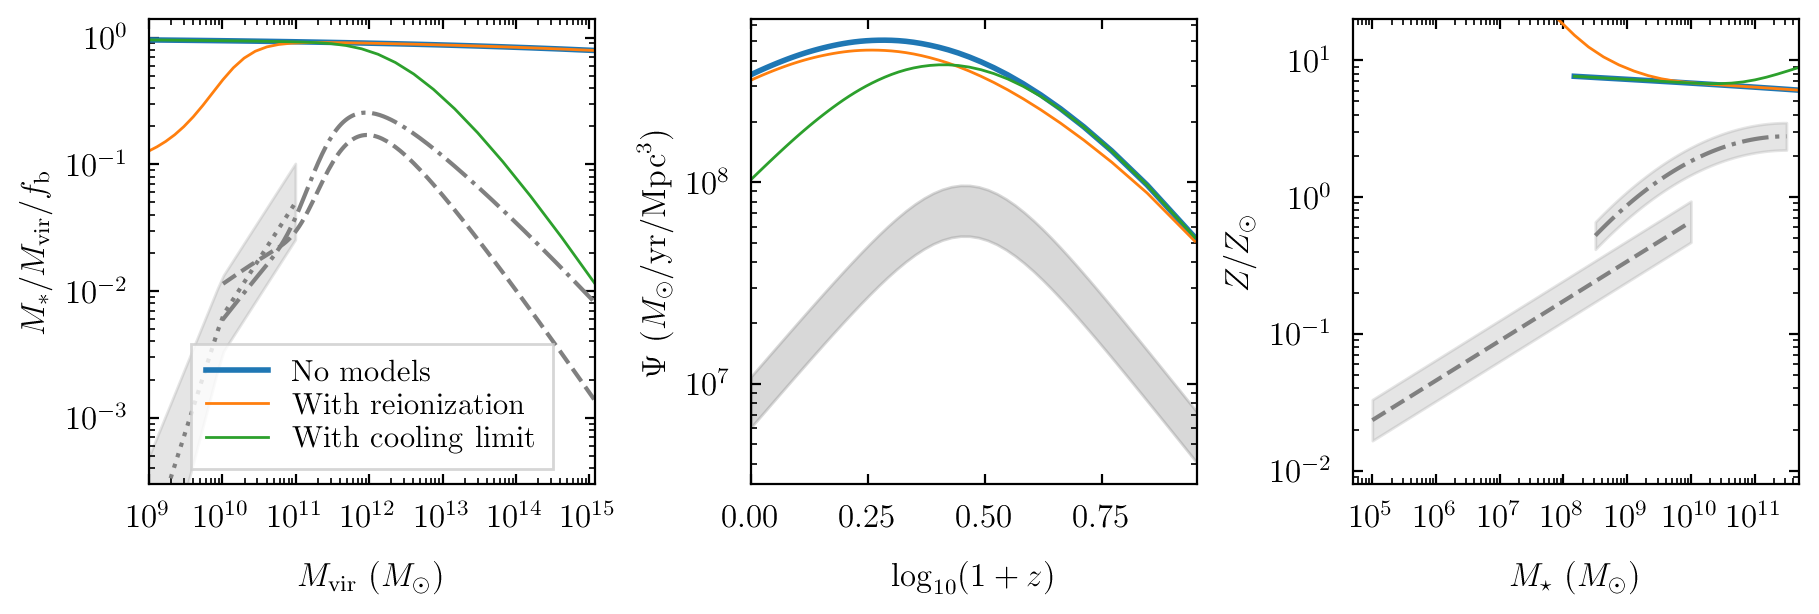

In [20]:
model_dics = [dic_cur, dic_reion, dic_coolcut]
labels = [r'$\mathrm{No\ models}$', r'$\mathrm{With\ reionization}$', r'$\mathrm{With\ cooling\ limit}$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

#### Details of the reionization model

The reionization model contains a few different parameters. Let's see how each of them affects the results.

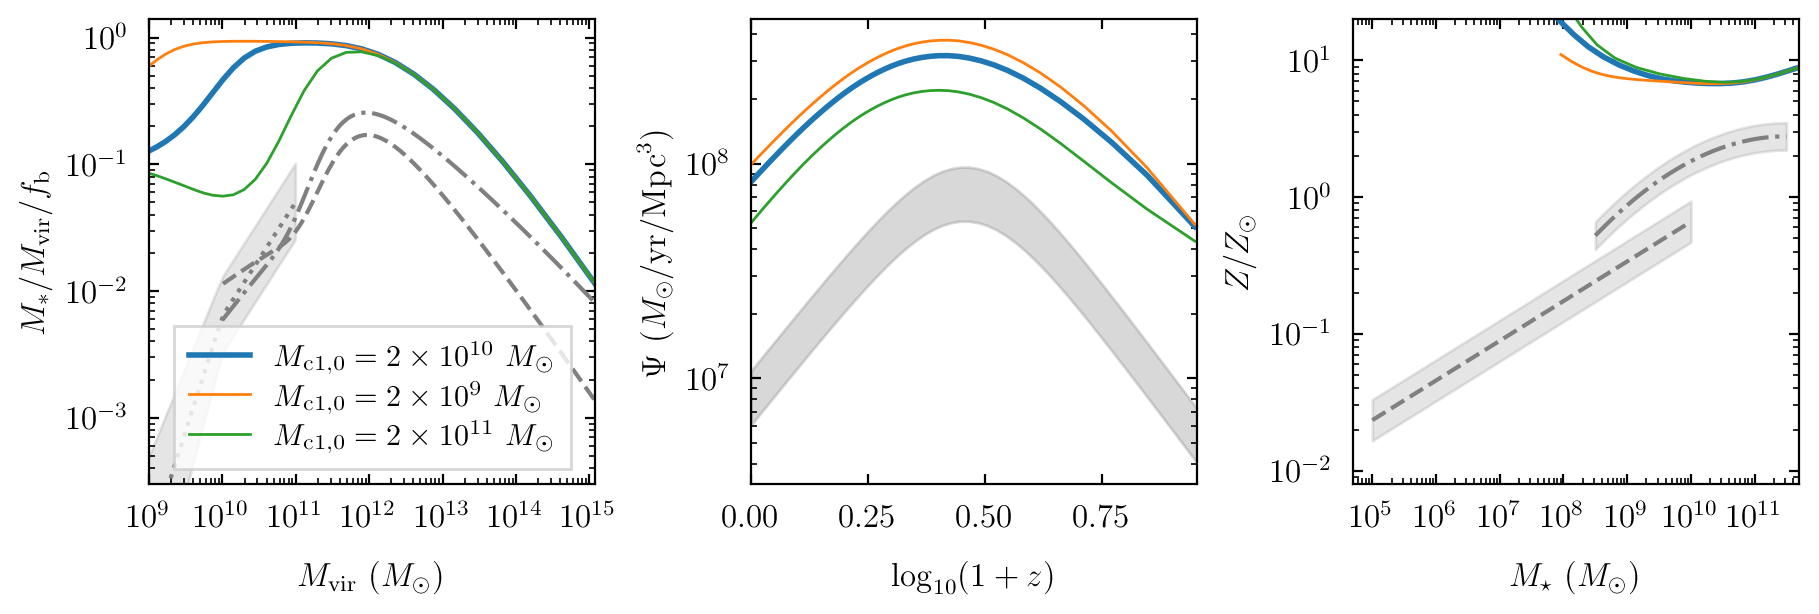

In [21]:
dic_cur = evaluateModel(**pars_cur)
dic_mreion_lo = evaluateModel(M_c1_0 = 2E9, **pars_cur)
dic_mreion_hi = evaluateModel(M_c1_0 = 2E11, **pars_cur)
model_dics = [dic_cur, dic_mreion_lo, dic_mreion_hi]
labels = [r'$M_{\rm c1,0} = 2 \times 10^{10}\ M_\odot$', 
          r'$M_{\rm c1,0} = 2 \times 10^{9}\ M_\odot$', r'$M_{\rm c1,0} = 2 \times 10^{11}\ M_\odot$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The mass below which halos cannot accrete baryons is critical. We set it so a somewhat higher (more conservative) number than the Okamoto et al. paper.

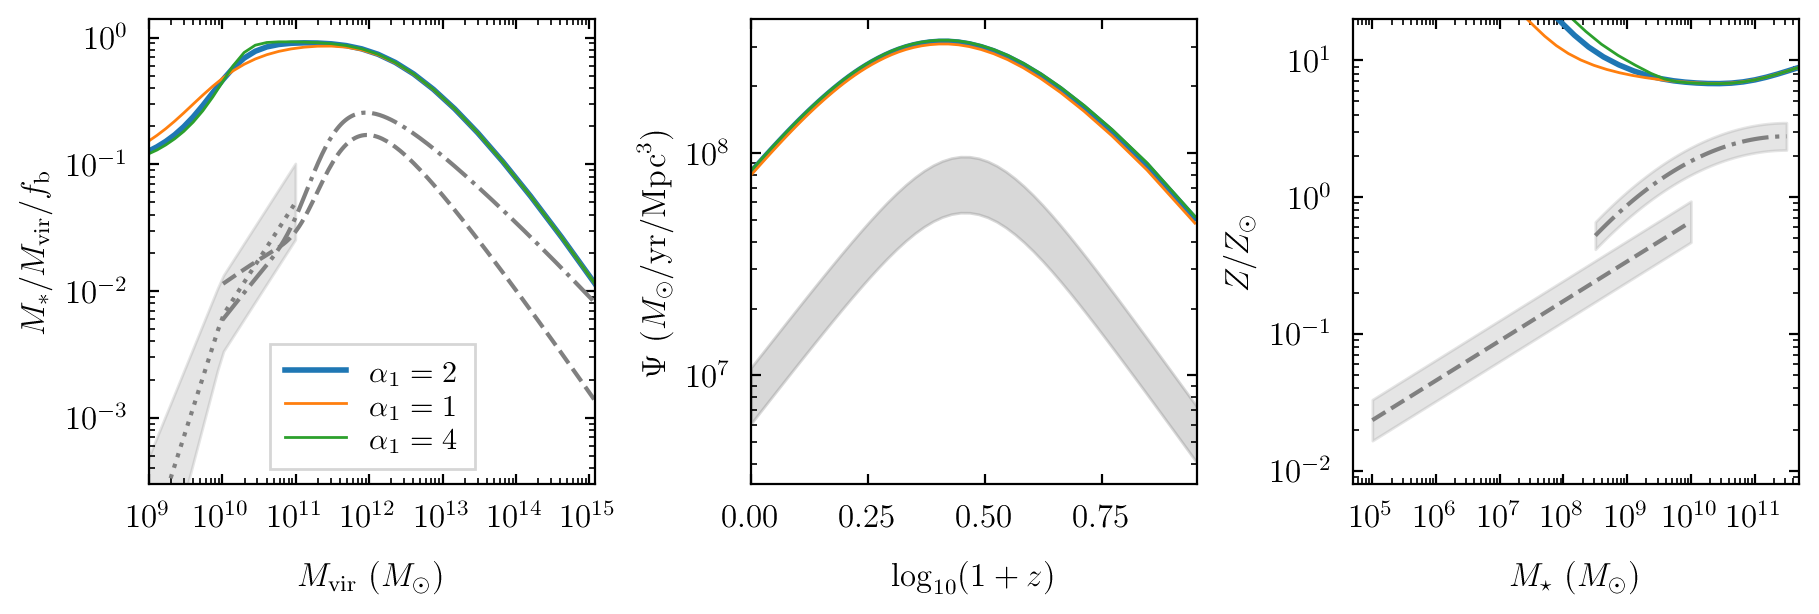

In [22]:
dic_alphareion_lo = evaluateModel(alpha1 = 1.0, **pars_cur)
dic_alphareion_hi = evaluateModel(alpha1 = 4.0, **pars_cur)
model_dics = [dic_cur, dic_alphareion_lo, dic_alphareion_hi]
labels = [r'$\alpha_1 = 2$', r'$\alpha_1 = 1$', r'$\alpha_1 = 4$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The $\alpha_1$ parameter determines how rapidly the cutoff happens. It does not make a huge difference.

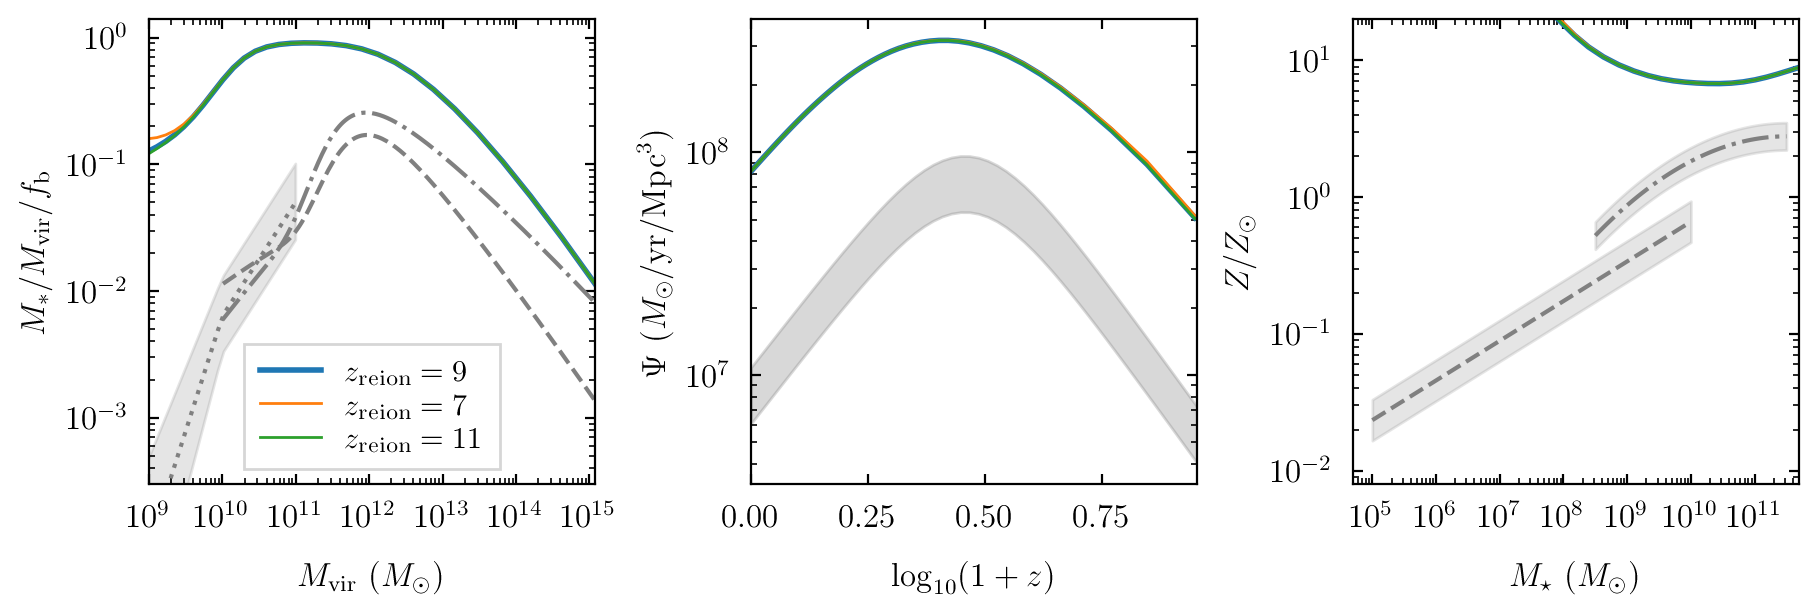

In [23]:
dic_zreion_lo = evaluateModel(z_reion = 7.0, **pars_cur)
dic_zreion_hi = evaluateModel(z_reion = 11.0, **pars_cur)
model_dics = [dic_cur, dic_zreion_lo, dic_zreion_hi]
labels = [r'$z_{\rm reion} = 9$', r'$z_{\rm reion} = 7$', r'$z_{\rm reion} = 11$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

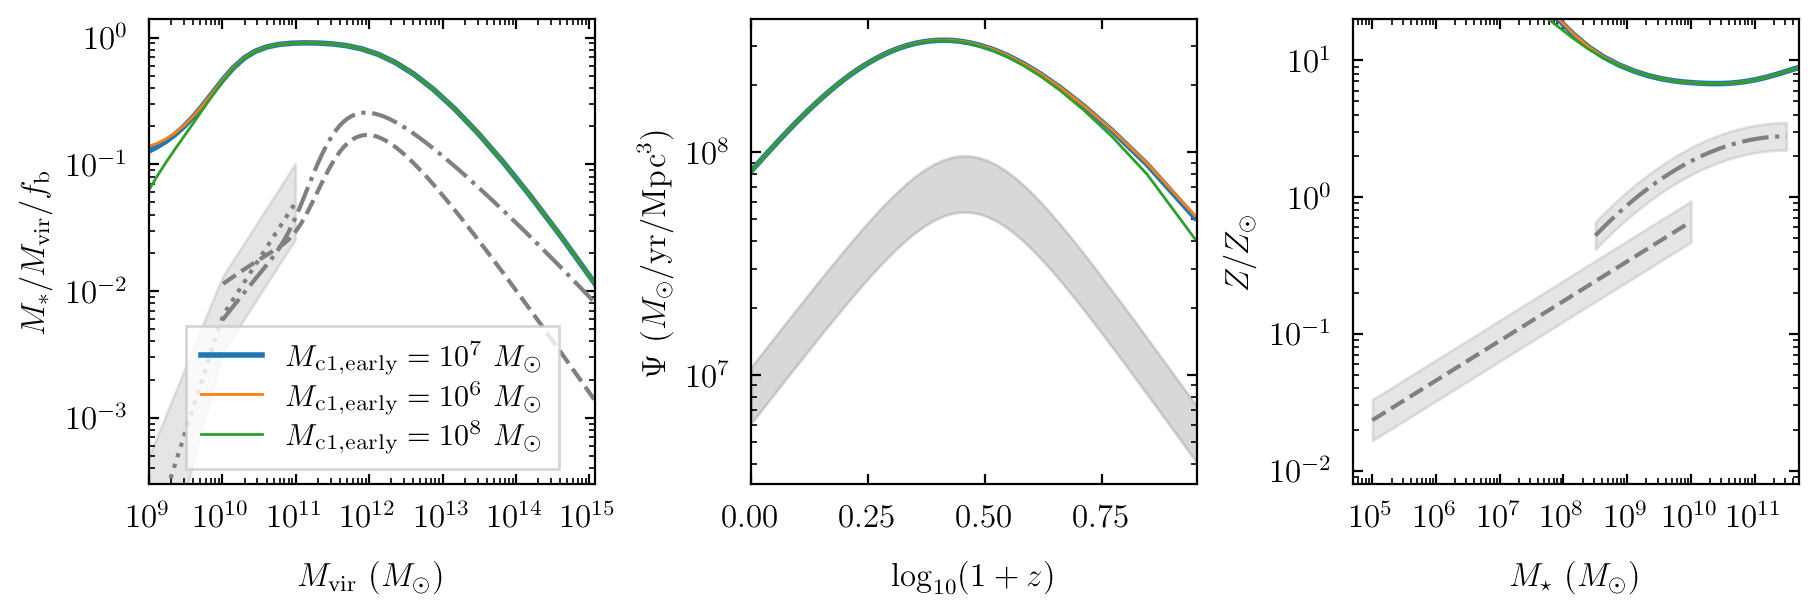

In [24]:
dic_mreionearly_lo = evaluateModel(M_c1_early = 1E6, **pars_cur)
dic_mreionearly_hi = evaluateModel(M_c1_early = 1E8, **pars_cur)
model_dics = [dic_cur, dic_mreionearly_lo, dic_mreionearly_hi]
labels = [r'$M_{\rm c1,early} = 10^7\ M_\odot$', r'$M_{\rm c1,early} = 10^6\ M_\odot$', 
          r'$M_{\rm c1,early} = 10^8\ M_\odot$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The redshift of reionization and the critical mass before reionization would make a difference only if we went down to lower halo masses.

#### Details of the cooling model

Let's explore the parameters of the cooling model.

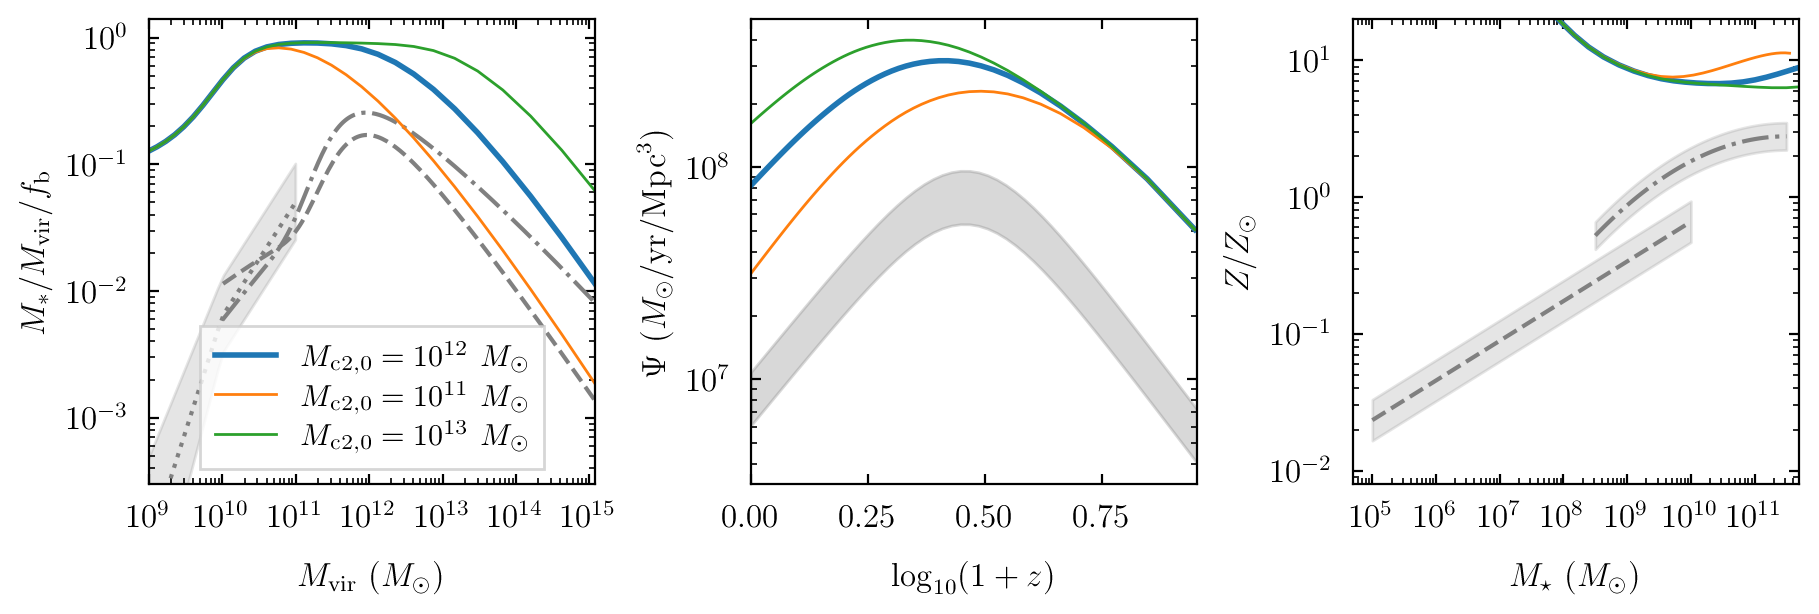

In [25]:
dic_mcooling_lo = evaluateModel(M_c2_0 = 1E11, **pars_cur)
dic_mcooling_hi = evaluateModel(M_c2_0 = 1E13, **pars_cur)
model_dics = [dic_cur, dic_mcooling_lo, dic_mcooling_hi]
labels = [r'$M_{\rm c2,0} = 10^{12}\ M_\odot$', r'$M_{\rm c2,0} = 10^{11}\ M_\odot$', 
          r'$M_{\rm c2,0} = 10^{13}\ M_\odot$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The mass where cooling becomes inefficient is clearly important for the high-mass end.

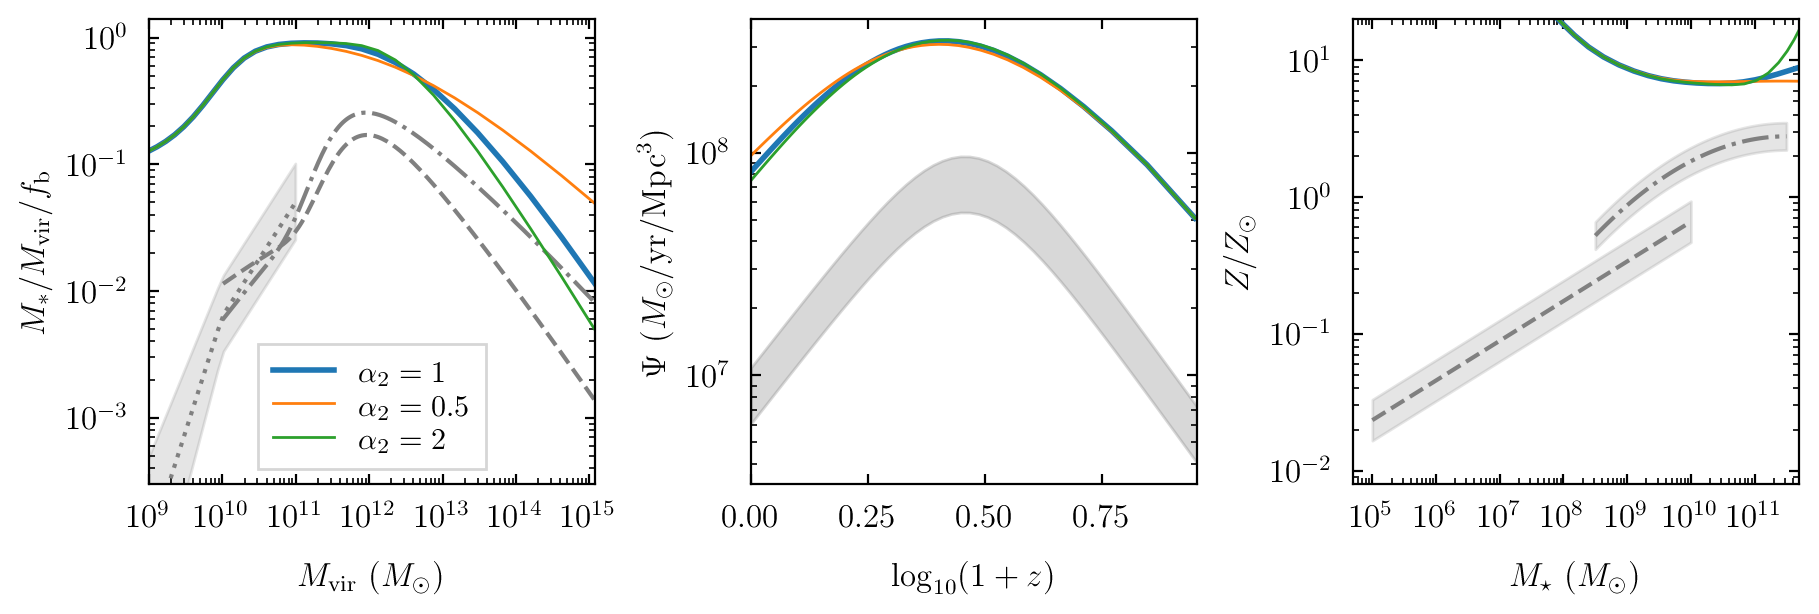

In [26]:
dic_alphacooling_lo = evaluateModel(alpha2 = 0.5, **pars_cur)
dic_alphacooling_hi = evaluateModel(alpha2 = 2.0, **pars_cur)
model_dics = [dic_cur, dic_alphacooling_lo, dic_alphacooling_hi]
labels = [r'$\alpha_2 = 1$', r'$\alpha_2 = 0.5$', r'$\alpha_2 = 2$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The $\alpha_2$ parameter does matter for the slope of the high-mass end.

#### Star formation law

We now add the losses due to the return of stellar material to the ISM.

In [27]:
del pars_cur['R_loss']
dic_cur = evaluateModel(**pars_cur)

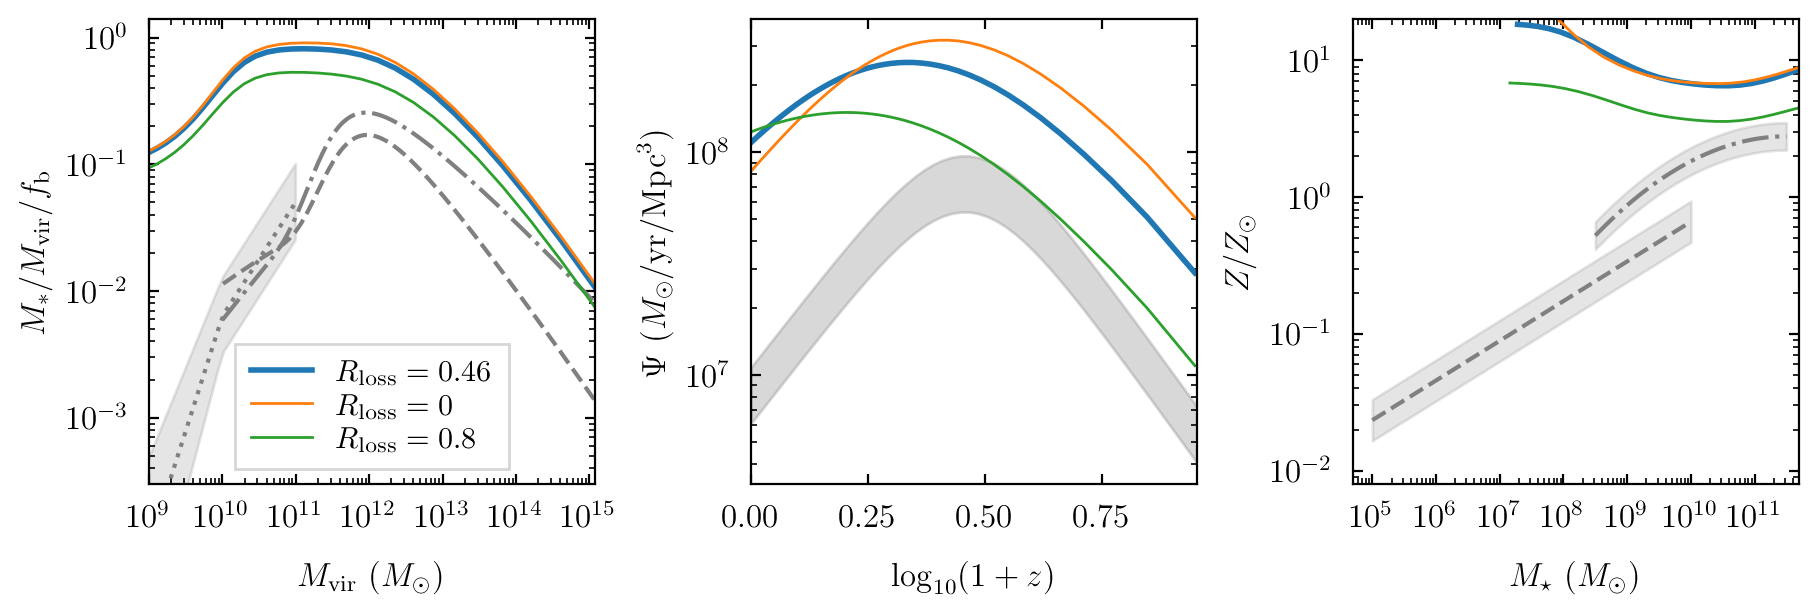

In [28]:
dic_rloss_lo = evaluateModel(R_loss = 0.0, **pars_cur)
dic_rloss_hi = evaluateModel(R_loss = 0.8, **pars_cur)
model_dics = [dic_cur, dic_rloss_lo, dic_rloss_hi]
labels = [r'$R_{\rm loss} = 0.46$', r'$R_{\rm loss} = 0$', r'$R_{\rm loss} = 0.8$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

The return rate matters, but it is not really a free parameter given an IMF.

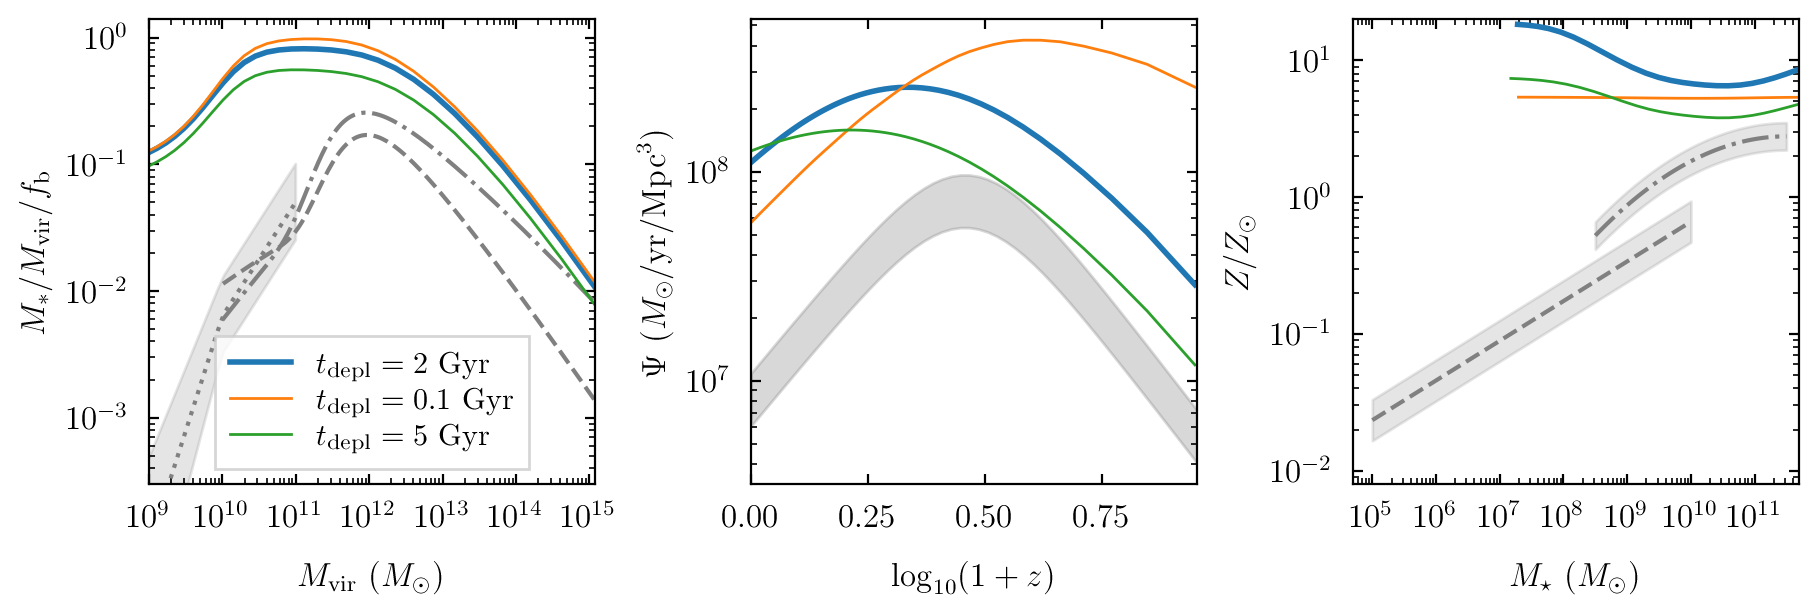

In [29]:
dic_tdepl_lo = evaluateModel(t_depl = 0.1, **pars_cur)
dic_tdepl_hi = evaluateModel(t_depl = 5.0, **pars_cur)
model_dics = [dic_cur, dic_tdepl_lo, dic_tdepl_hi]
labels = [r'$t_{\rm depl} = 2\ {\rm Gyr}$', r'$t_{\rm depl} = 0.1\ {\rm Gyr}$', 
          r'$t_{\rm depl} = 5\ {\rm Gyr}$']
plotModels(model_dics, labels, shmr_y_max = 1.4, mz_y_max = 2E1)

One would expect the depletion time to be extremely important, since it acts as the normalization of the SFR. While the global SFR of the Universe is indeed highly sensitive to $t_{\rm depl}$, the SHMR is barely sensitive to it at all. This highlights that the SFR may control how quickly stars are formed, but that the eventual stellar mass of galaxies is set by the amount of gas they can accrete and cool (as well as feedback, as we will see momentarily).

#### Feedback model

In [30]:
# We have now arrived at our fiducial model with no added parameters
del pars_cur['model_wind']
del pars_cur['eta_min']
dic_fid = evaluateModel(**pars_cur)
dic_cur = dic_fid

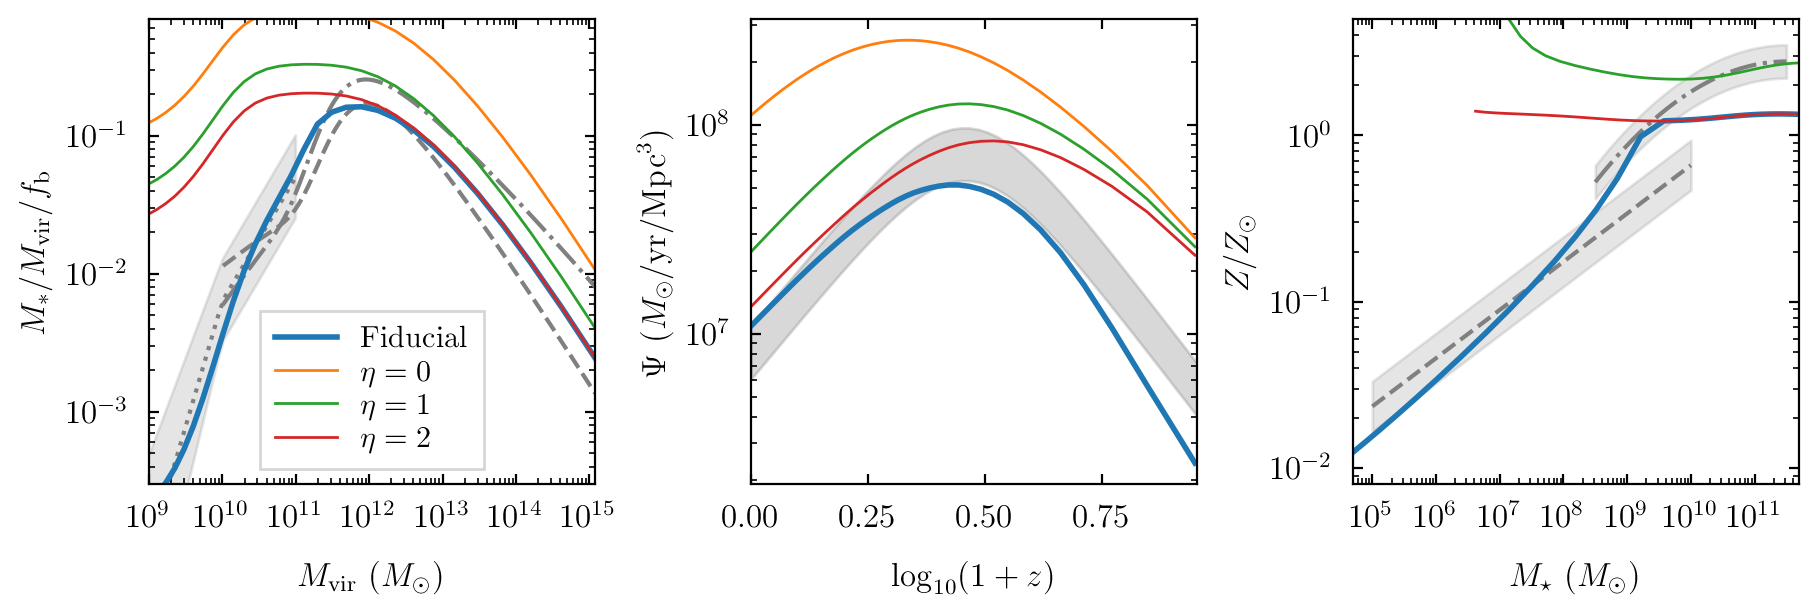

In [31]:
dic_wind_eta0 = evaluateModel(model_wind = 'fixed', eta_fixed = 0.0, eta_min = 0.0)
dic_wind_eta1 = evaluateModel(model_wind = 'fixed', eta_fixed = 1.0, eta_min = 0.0)
dic_wind_eta2 = evaluateModel(model_wind = 'fixed', eta_fixed = 2.0, eta_min = 0.0)

model_dics = [dic_cur, dic_wind_eta0, dic_wind_eta1, dic_wind_eta2]
labels = [r'$\mathrm{Fiducial}$', r'$\eta = 0$', r'$\eta = 1$', r'$\eta = 2$']
plotModels(model_dics, labels, save = save_plots, fn_out = 'sam_eta_fixed.pdf')

Clearly, constant mass loading factors cannot reproduce any of our observational constraints.

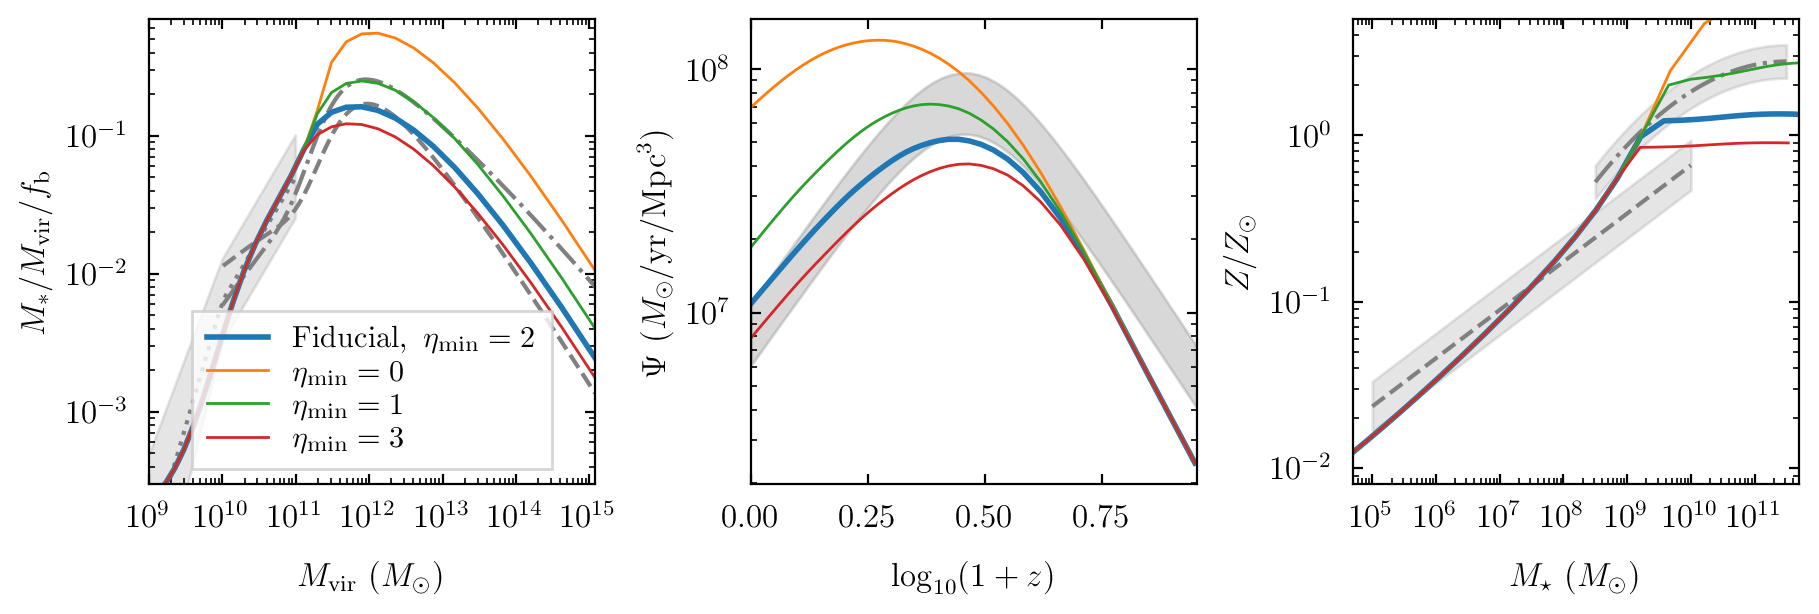

In [32]:
dic_wind_etamin0 = evaluateModel(eta_min = 0.0)
dic_wind_etamin1 = evaluateModel(eta_min = 1.0)
dic_wind_etamin3 = evaluateModel(eta_min = 3.0)

model_dics = [dic_cur, dic_wind_etamin0, dic_wind_etamin1, dic_wind_etamin3]
labels = [r'$\mathrm{Fiducial},\ \eta_{\rm min} = 2$', r'$\eta_{\rm min} = 0$', 
          r'$\eta_{\rm min} = 1$', r'$\eta_{\rm min} = 3$']
plotModels(model_dics, labels)

The minimum mass loading factor acts only at high masses, since our feedback model leads to $\eta \gg \eta_{\rm min}$ at low masses. No minimum feedback at all is ahrd to reconcile with observations.

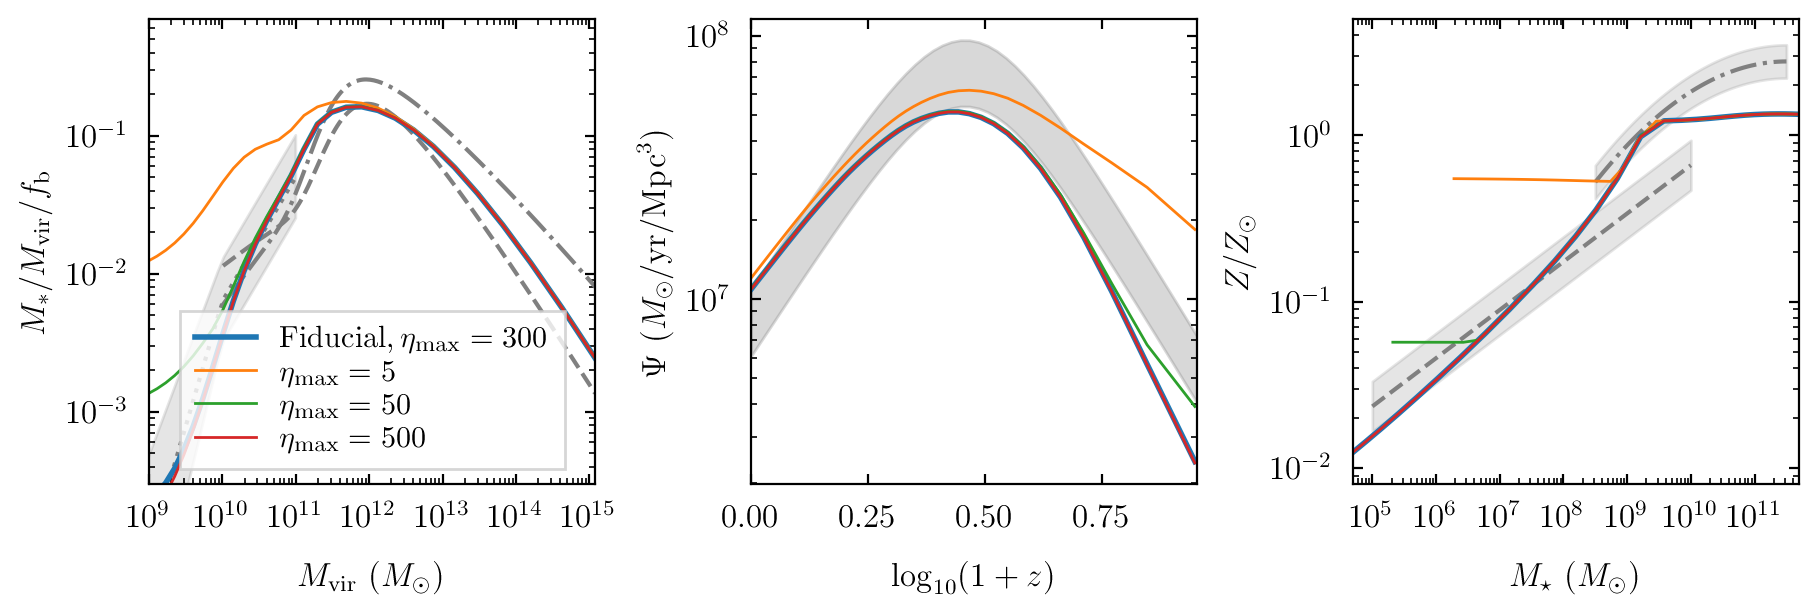

In [33]:
dic_wind_etamax0 = evaluateModel(eta_max = 5.0)
dic_wind_etamax1 = evaluateModel(eta_max = 50.0)
dic_wind_etamax2 = evaluateModel(eta_max = 500.0)

model_dics = [dic_cur, dic_wind_etamax0, dic_wind_etamax1, dic_wind_etamax2]
labels = [r'$\mathrm{Fiducial}, \eta_{\rm max} = 300$', r'$\eta_{\rm max} = 5$', 
          r'$\eta_{\rm max} = 50$', r'$\eta_{\rm max} = 500$']
plotModels(model_dics, labels, save = save_plots, fn_out = 'sam_eta_max.pdf')

Clearly, the extremely high values of $\eta$ are really needed to suppress star formation in low-mass halos!

### Model summary

In the plots above, we built our model component by component. As a final summary, let's see how the results change compared to the final model when we leave out critical components.

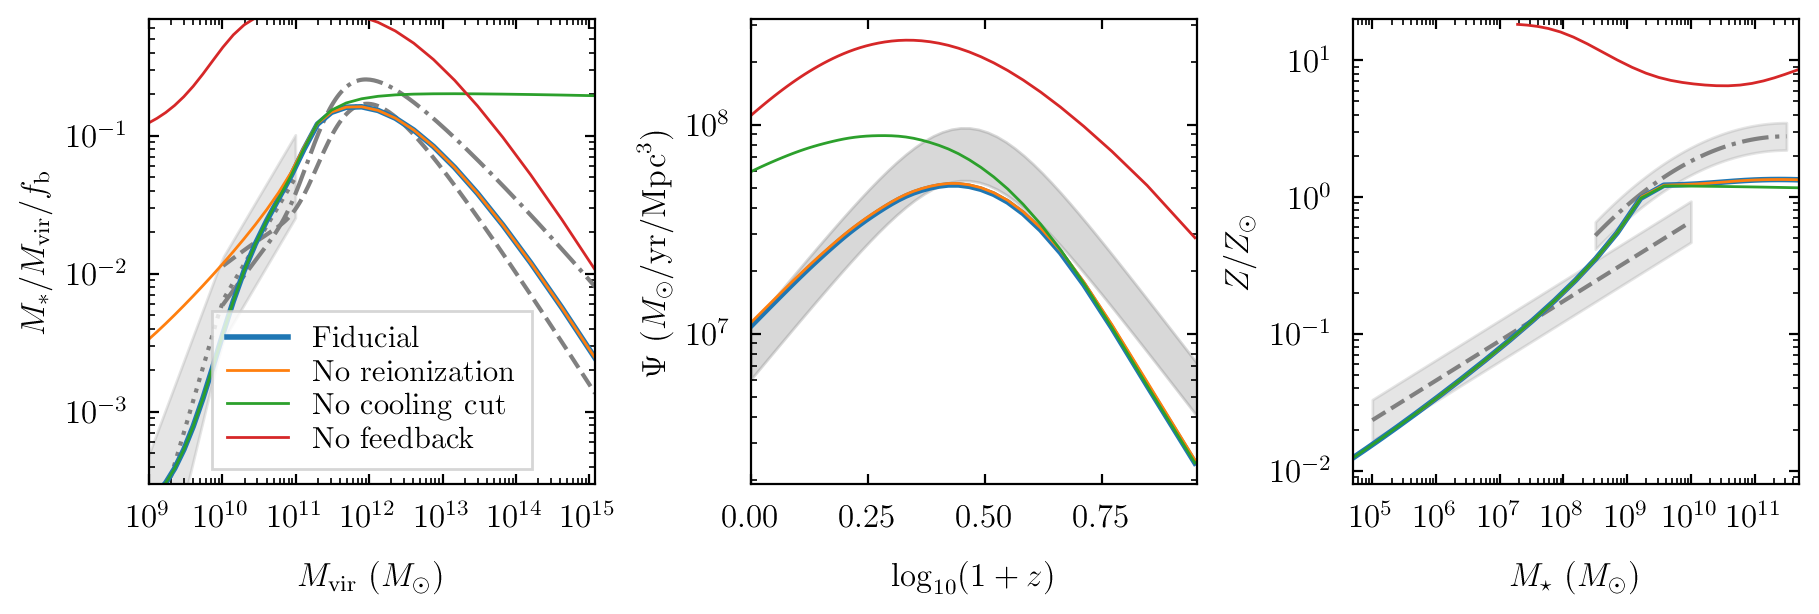

In [34]:
dic_no_reion = evaluateModel(model_reion = 'none')
dic_no_cool = evaluateModel(model_cooling = 'none')
dic_no_wind = evaluateModel(model_wind = 'none', eta_min = 0.0)

model_dics = [dic_cur, dic_no_reion, dic_no_cool, dic_no_wind]
labels = [r'$\mathrm{Fiducial}$', r'$\mathrm{No\ reionization}$', 
          r'$\mathrm{No\ cooling\ cut}$', r'$\mathrm{No\ feedback}$']
plotModels(model_dics, labels, save = save_plots, fn_out = 'sam_modelcomp.pdf', mz_y_max = 2E1)

### Saving results

For use in other notebooks, we save the results of our fiducial model to a pickle.

In [35]:
import pickle

fn = cmn.data_dir + 'tmp_files/sam_fiducial'
output_file = open(fn, 'wb')
pickle.dump(dic_cur, output_file)
output_file.close()